# Porte NOT

## Import and Formatting

The goal of this section is to import all the necessary files and libraries required for the subsequent data analysis.  
It also includes setting up the formatting parameters for the plots and visualizations.

### Import

In [1]:
# ----  Standard import
import matplotlib.pyplot as plt
import numpy as np

# ----- Spice import
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

### Formatting

Adjusting Plotly chart settings for clarity and consistency.

In [2]:
# ----  Formatting charts
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.edgecolor']  = "#bcbcbc"
mpl.rcParams['patch.linewidth'] = 0.5
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['axes.facecolor']  = "#eeeeee"
mpl.rcParams['axes.labelsize']  = "large"
mpl.rcParams['axes.grid']       = True
mpl.rcParams['grid.linestyle']  = "--"
mpl.rcParams['patch.edgecolor'] = "#eeeeee"
mpl.rcParams['axes.titlesize']  = "x-large"

## Introduction

NOT gates are one of the most important logic gates for several reasons. First of all, these circuits are found everywhere in digital systems, making them one of the most fundamental building blocks in logic circuit design.

The truth table is relatively simple:

```{table} Table de vérité NOT
:name: Table_de_verite_d_une_porte_NOT
:align: center

| A | Y |
| - | - |
| 0 | 1 |
| 1 | 0 |
```

The purpose of a NOT gate is simply to invert its input: if the input is `0`, the output is `1`, and if the input is `1`, the output is `0`.

## Symbol

A NOT gate is relatively simple ([](#symbol_not)): it has one input and one output. Inside the rectangle, the symbol `1` indicates that it is a buffer (also called a non-inverting gate). The small triangle at the output represents the inversion, indicating that this is an inverting gate.

```{figure} ./images/symbol_not.svg
:name: symbol_not
:align: center
:width: 400px

Symbol of a NOT gate
```

This is therefore a very simple gate. In the next section, the objective is to build a NOT gate using CMOS technology, and more importantly, to understand the underlying equations.

## CMOS Construction

### Electronic Circuit

The electronic schematic ([](#circuit_electronique_CMOS_NOT)) is relatively simple. It consists of two CMOS transistors connected through their drains: one NMOS transistor and one PMOS transistor.

```{figure} ./images/CMOS_NOT.svg
:name: circuit_electronique_CMOS_NOT
:align: center
:width: 300px

Electronic circuit of a CMOS NOT gate
```

The operation of this circuit is fairly intuitive to understand ([](#CMOS_NOT_demonstration)).

```{figure} ./images/CMOS_NOT_demonstration.svg
:name: CMOS_NOT_demonstration
:align: center
:width: 400px

CMOS NOT gate operation demonstration
```

When the input value is at logic level `0`, transistor M2 (NMOS) is turned off while transistor M1 (PMOS) is turned on. The output is therefore connected to $V_{DD}$, resulting in a high logic level `1` at the output.

Conversely, when the input value is at logic level `1`, transistor M1 is turned off and transistor M2 becomes conductive. The output is then connected to ground, leading to a low logic level `0`.

### Simulation Spice



In [3]:
# ============================================================
# CMOS AND Gate
# Implemented as NAND gate followed by an inverter
# ============================================================

# Create the circuit
circuit = Circuit('CMOS AND')

# Include transistor models
circuit.include('lib/ptm_65nm_nmos_bulk.mod')
circuit.include('lib/ptm_65nm_pmos_bulk.mod')

# ============================================================
# Power Supply
# ============================================================

VDD = 1.2
circuit.V('dd', 'vdd', circuit.gnd, VDD @ u_V)

# ============================================================
# Input Signal Definitions
# ============================================================

circuit.PulseVoltageSource(
    'A',
    'va',
    circuit.gnd,
    0 @ u_V, VDD @ u_V,
    pulse_width=5/2 @ u_ns,
    period=10/2 @ u_ns
)

# ============================================================
# CMOS Inverter
# ============================================================

circuit.MOSFET(
    1,
    'vout', 'va', 'vdd', 'vdd',
    model='ptm65nm_pmos',
    l=0.35 @ u_um,
    w=0.3 @ u_um
)

circuit.MOSFET(
    2,
    'vout', 'va', circuit.gnd, circuit.gnd,
    model='ptm65nm_nmos',
    l=0.35 @ u_um,
    w=0.3 @ u_um
);

In [4]:
# ============================================================
# Simulation Setup
# Transient analysis of the CMOS logic gate
# ============================================================

# Create the simulator instance
# Temperature parameters are set to nominal operating conditions
simulator = circuit.simulator(
    temperature=25,
    nominal_temperature=25
)

# ============================================================
# Transient Analysis
# ============================================================

# Perform a transient simulation to observe the dynamic behavior
# of the inputs (A, B) and the output (Vout)
analysis = simulator.transient(
    step_time = 0.05 @ u_ns,
    end_time  = 10 @ u_ns
)

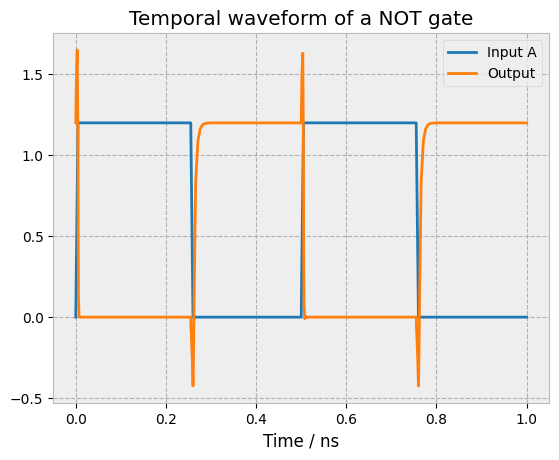

In [5]:
# Plot the transient waveforms
plt.figure()
plt.title("Temporal waveform of a NOT gate")

# Input signals (shifted vertically for clarity)
plt.plot(analysis.time * 1e8, np.array(analysis["va"]), label="Input A")

# Output signal
plt.plot(analysis.time * 1e8, analysis["vout"], label="Output")

# Axis labels and legend
plt.xlabel("Time / ns")
plt.legend()
plt.show()

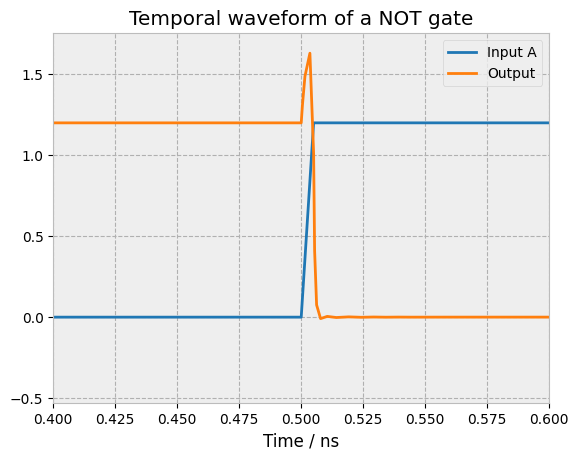

In [6]:
# Plot the transient waveforms
plt.figure()
plt.title("Temporal waveform of a NOT gate")

# Input signals (shifted vertically for clarity)
plt.plot(analysis.time * 1e8, np.array(analysis["va"]), label="Input A")

# Output signal
plt.plot(analysis.time * 1e8, analysis["vout"], label="Output")

# Axis labels and legend
plt.xlim(.4, .6)
plt.xlabel("Time / ns")
plt.legend()
plt.show()

There are two key points to understand. First, the output waveform clearly shows the inverter behavior of the system: when the input is `1`, the output is `0`, and conversely, when the input is `0`, the output is `1`.

The second important point is that this transition is not ideal. It can be observed that there is a voltage drop followed by a ramp as the output rises toward the value of $V_{DD}$.

In the remainder of the report, one of the objectives is to study how to correct, improve, or at least control this transition behavior.

In [7]:
# ============================================================
# Simulation Setup
# Transient analysis of the CMOS logic gate
# ============================================================

# Create the simulator instance
# Temperature parameters are set to nominal operating conditions
simulator = circuit.simulator(
    temperature=25,
    nominal_temperature=25
)

# ============================================================
# Transient Analysis
# ============================================================

analysis = simulator.dc(
    Va=slice(0, 1.2, 0.01)
)

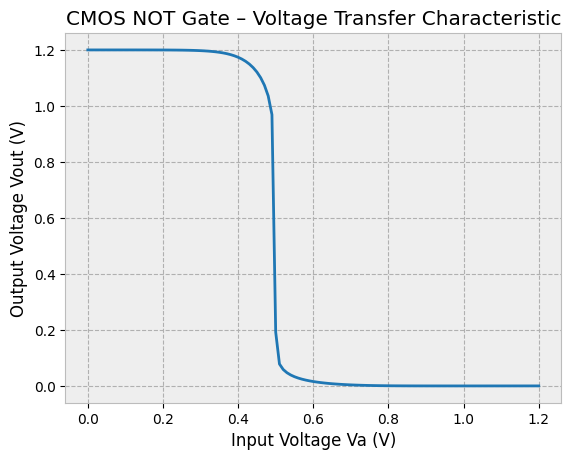

In [10]:
# Plot the voltage transfer characteristic (VTC) of the NOT gate
plt.figure()
plt.title("CMOS NOT Gate – Voltage Transfer Characteristic")

# Output voltage as a function of input voltage
plt.plot(analysis["va"], analysis["vout"])

# Axis labels
plt.xlabel("Input Voltage Va (V)")
plt.ylabel("Output Voltage Vout (V)")

plt.show()

### Switching Threshold Value

Figure [](#CMOS_NOT_demonstration_aide2) helps to better understand the equations involved in the analysis.

```{figure} ./images/CMOS_NOT_demonstration_aide.svg
:name: CMOS_NOT_demonstration_aide2
:align: center
:width: 400px

Electronic circuit of a CMOS NOT gate with the different node voltages
```

#### Transistor Threshold Voltage

The objective of this section is to calculate the switching threshold of the system, that is, the point at which the inverter transitions from the high logic state `1` to the low logic state `0`.

To begin with, in our case, for CMOS transistors, the bulk and the source are at the same potential because they are short-circuited, as shown in the figure above. Under this condition, the body effect can be neglected.

Thus, the threshold voltage can be written as:

$$V_{THx} = V_{TH0}$$

with:

$$V_{TH0} = V_{FB} + 2\phi_F$$

where:

* $V_{FB}$ is the flat-band voltage,
* $\phi_F$ is the Fermi potential.

In the simulation model files, the value of $V_{TH0}$ is directly provided:

```text
"ptm_65nm_nmos_bulk.mod"
+vth0 = 0.429
```

```text
"ptm_65nm_pmos_bulk.mod"
+vth0 = -0.378
```

Therefore, the threshold voltages are:

$$V_{THN} = 0.429\ \text{V}$$

$$V_{THP} = -0.378\ \text{V}$$

#### Transistor Output Current

The switching threshold corresponds to the operating point at which the NMOS and PMOS drain currents are equal. In other words, the currents flowing through transistors $M_1$ (NMOS) and $M_2$ (PMOS) are the same. This condition can be written as:

$$I_{NMOS} = I_{PMOS}$$

To compute the drain current, the long-channel MOSFET saturation model is used:

$$I_D = \frac{1}{2},\beta,(V_{OV})^2$$

where:

* $\beta$ is the gain factor: $\beta = \mu C_{ox} \frac{W}{L}$

  * $\mu C_{ox}$ is the technology-dependent parameter,
  * $\frac{W}{L}$ is the geometrical factor of the transistor,
* $V_{OV}$ is the overdrive voltage, defined as:
  $$
  V_{OV} = V_{GS} - V_{TH}
  $$

#### Overdrive Voltage

The overdrive voltage $V_{OV}$ appears when the gate-to-source voltage $V_{GS}$ exceeds the threshold voltage $V_{TH}$:

$$V_{GS} > V_{TH}$$

It is given by:

$$V_{OV} = V_{GS} - V_{TH}$$

By analyzing both transistors in the CMOS inverter, the overdrive voltages can be expressed as follows.

**PMOS transistor: $V_{OV,p}$**

$$V_{OV,p} = V_{GS,p} - |V_{THP}|$$

$$V_{OV,p} = V_G - V_S - |V_{THP}|$$

$$V_{OV,p} = V_{in} - V_{DD} - |V_{THP}|$$

$$\boxed{V_{OV,p} = V_{in} - V_{DD} - |V_{THP}|}$$

**NMOS transistor: $V_{OV,n}$**

$$V_{OV,n} = V_{GS,n} - V_{THN}$$

$$V_{OV,n} = V_G - V_S - V_{THN}$$

$$V_{OV,n} = V_{in} - 0 - V_{THN}$$

$$\boxed{V_{OV,n} = V_{in} - V_{THN}}$$

#### Switching Threshold Calculation

As stated previously, the transition occurs when the NMOS and PMOS drain currents are equal:

$$I_{NMOS} = I_{PMOS}$$

Using the saturation current expression:

$$I_D = \frac{1}{2},\beta,(V_{OV})^2$$

we obtain:

$$I_{PMOS} = \frac{1}{2},\beta_p,(V_{in} - V_{DD} - |V_{THP}|)^2$$
$$I_{NMOS} = \frac{1}{2},\beta_n,(V_{in} - V_{THN})^2$$

Equating both currents gives:

$$\frac{1}{2} \cdot \beta_n (V_{in} - V_{THN})^2 = \frac{1}{2} \cdot \beta_p (V_{in} - V_{DD} - |V_{THP}|)^2$$
$$\beta_n (V_{in} - V_{THN})^2 = \beta_p (V_{in} - V_{DD} - |V_{THP}|)^2$$
$$\mu_n Cox_n \frac{L_n}{W_n} (V_{in} - V_{THN})^2 = \mu_p Cox_p \frac{L_p}{W_p} (V_{in} - V_{DD} - |V_{THP}|)^2$$

At this stage, the analytical expression becomes cumbersome to solve directly. Therefore, the study is intentionally stopped here. In practice, the switching threshold is often obtained numerically from simulation or by making simplifying assumptions (such as symmetric sizing or equalized $\beta$ ratios).

## Microelectronics

The objective of this section is to **reconstruct and understand the layout (layer view) of a NOT gate**.
The NOT gate is the **simplest CMOS logic gate**, which makes it an ideal starting point for understanding CMOS layout principles.

### Layout Representation

At first glance, the layout shown in [](#CMOS_layer_not) may look very different from the corresponding CMOS schematic [](#circuit_electronique_CMOS_NOT).

To understand this layout, the first step is to **identify the input and the output**.

* The **input `A`** is located on the **red vertical line**.
  This line connects the gates of both CMOS transistors: the PMOS and the NMOS.

* The **output `Y`** is located on the **right side of the layout**.
  It corresponds to the **drain connection shared by both transistors**.

### Identification of the Transistors

From the layout, we can clearly identify the two CMOS transistors:

* The **PMOS transistor (pull-up transistor)** is located in the **upper part** of the layout.
* The **NMOS transistor (pull-down transistor)** is located in the **lower part** of the layout.

This vertical arrangement is typical in CMOS design and reflects the logical function of the inverter:

* PMOS connects the output to **VDD** when the input is low
* NMOS connects the output to **GND** when the input is high


### Doping Regions and Substrate

To fully understand the layout, it is also important to identify the doping regions:

* The **green area** represents the **substrate (bulk)**, which is **positively doped**.
* The **orange regions** correspond to **negatively doped areas**, where the source and drain regions of the transistors are formed.

These doping regions define the electrical behavior of the transistors and allow current to flow when the devices are activated.


```{figure} ./images/layer_not.svg
:name: CMOS_layer_not
:align: center
:width: 200px

CMOS layout of a NOT gate
```

## Reference 

## Writing Matrix

| Author | Reviewer | Approver | Section | Date 1 | Date 2 | Date 3 | General Remarks |
|--------|----------|----------|---------|--------|--------|--------|------------------|
| Sacha  | /        | /        | Entire document | 2026-01-07 | / | / | Initial draft of the full document |